# Lab Assignment Six: Convolutional Network Architectures

Miller Boyd

## Introduction
In this lab, we will select a prediction task to perform on my dataset, evaluate a deep learning architecture, and tune hyper-parameters. This report aims to be comprehensive, containing all code, visualizations, and text required to reproduce the results. We will explain every assumption and each step taken in my analysis.

## Dataset
Cards Image Dataset for Classification

from kaggle:

About Dataset

This is a very high quality dataset of playing card images. All images are 224 X 224 X 3 in jpg format. All images in the dataset have been cropped so that only the image of a single card is present and the card occupies well over 50% of the pixels in the image. There are 7624 training images, 265 test images and 265 validation images. The train, test and validation directories are partitioned into 53 sub directories , one for each of the 53 types of cards. The dataset also includes a csv file which can be used to load the datasets.

## Dataset Selection
For this lab, we will select a dataset of image data, similarly to how we selected datasets in lab two. The dataset will consist of identically sized images and will be used for a multi-class classification task. We are not allowed to use MNIST, Fashion MNIST, or the sklearn digits dataset.

For this lab, I've chosen a dataset of playing card images, which meets my criteria of using image data for a multi-class classification task. This choice avoids common datasets like MNIST or Fashion MNIST, providing a fresh and challenging alternative.
Why Playing Cards?

    Diverse Classes: Each card in a deck offers a unique image, creating over 52 distinct classes to classify. This diversity tests the depth and effectiveness of convolutional neural networks.

    Consistent Image Sizes: Playing cards are uniformly sized, simplifying preprocessing and allowing us to focus more on model tuning rather than data wrangling.

    Augmentation Opportunities: The dataset lends itself well to image transformations such as rotations and flips, enhancing the robustness of my model by training it to recognize cards from various perspectives.

    Real-world Relevance: The ability to automatically recognize playing cards can be applied in digital gaming, automated card games, and even casino security, making this project practically applicable beyond academic purposes.

    Unique Challenge: Stepping away from overused datasets introduces us to unique challenges in image processing and deep learning, pushing us to deepen my understanding and skills in a real-world context.

In [ ]:
import pandas as pd
from PIL import Image
import os

# Load the CSV file to get image paths
data_path = './images/cards.csv'
df = pd.read_csv(data_path)

# Base directory where your images are stored relative to this notebook
base_directory = './images/'

# Function to load an image
def load_image(image_path):
    try:
        full_path = os.path.join(base_directory, image_path)
        with Image.open(full_path) as img:
            return img.copy()
    except IOError:
        print(f"Error opening image {full_path}")
        return None

# Apply the function to load images
df['image'] = df['filepaths'].apply(load_image)

df.head()


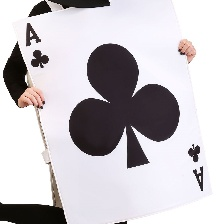

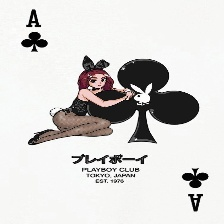

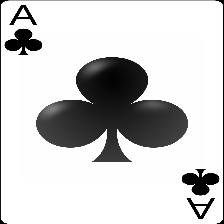

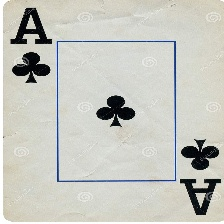

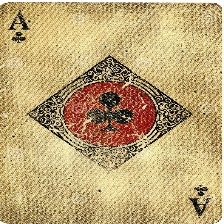

In [102]:
for x in range(5): display(df.loc[x, 'image'])

In [103]:
df['target'] = df['labels'].astype('category').cat.codes
df['card_val'] = df['card type'].astype('category').cat.codes

print(df['target'].unique())
print(df['card_val'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
[ 0  1  2  3  4 13  5  6  7  8  9 10 11 12]


I have encoded all card string names to an int value for ease of processing :). Now to clean up the dataset and remove uneccesary columns.

In [104]:
df = df.drop(columns=['class index','data set','labels','card type'])

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8155 entries, 0 to 8154
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  8155 non-null   object
 1   image      8154 non-null   object
 2   target     8155 non-null   int8  
 3   card_val   8155 non-null   int8  
dtypes: int8(2), object(2)
memory usage: 143.5+ KB


,target,card_val
count,8155.000000,8155.000000
mean,25.765788,6.036297
std,15.315650,3.812140
min,0.000000,0.000000
25%,12.000000,3.000000
50%,26.000000,6.000000
75%,39.000000,9.000000
max,52.000000,13.000000


### Preparation (3 points total)
#### Metric Selection (1.5 points)
Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

The F1 Score is a harmonic mean of precision and recall. This balance is crucial because in the context of card classification, both false positives and false negatives carry significant weight. For example, incorrectly classifying a card in a digital game or security system could disrupt the gameplay or trigger false alerts, respectively. Therefore, optimizing both precision (the accuracy of positive predictions) and recall (the ability to find all relevant instances) is essential.

In [105]:
from tensorflow.keras.metrics import Metric, Precision, Recall
import tensorflow as tf

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
    
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


#### Data Splitting Method (1.5 points)
Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

For my playing card image classification task, I've chosen to use Stratified Shuffle Split for dividing my data into training and testing sets. I picked this method for a few practical reasons that make sense for my specific needs and the nature of my data:

    Preservation of Class Distribution: my dataset probably doesn't have an even distribution of card types—some are likely more common than others. Using stratified sampling helps make sure that every training and test set mirrors the full dataset's class distribution, which is key to keeping my model fair and effective across all card types.

    Randomization: Shuffle splits add randomness to how we pick data points for the training and test sets. This is great for making the model more generalizable, reducing any bias that could come from the order of the data.

    Flexibility in Dataset Size: This method lets us choose exactly how much of my data to hold back for testing. This flexibility allows me to tailor the split based on how much data we have and what my training versus validation needs are.

    Realistic Mirroring of Practical Use: In real life, a model won't always get uniformly distributed data. The Stratified Shuffle Split mimics real-world conditions by ensuring the data split is both representative of the overall distribution and randomly shuffled. This approach helps prepare the model for how it will actually encounter data in practice, enhancing its reliability and effectiveness when deployed.

These reasons make Stratified Shuffle Split a solid choice for managing my data, aiming for a model that's both robust and closely aligned with real-world application requirements.

In [119]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import to_categorical

# Filter out rows where the image is None
filtered_df = df[df['image'].notnull()]

# Normalize pixel values
X = np.array([np.array(img) / 255.0 for img in filtered_df['image']])
print(X.shape)
y = filtered_df['card_val'].values
print(y.shape)

y_one_hot = to_categorical(y, num_classes=14)

# Define the Stratified Shuffle Split object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]


(8154, 224, 224, 3)
(8154,)


### Modeling (6 points total)

#### Data Augmentation in Keras (1.5 points)
Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You should make use of Keras augmentation layers, like in the class examples.

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomFlip, RandomTranslation

cnn = Sequential()

cnn.add(RandomRotation(factor=0.1))  # Rotates the image by +/- 10% of 360 degrees
cnn.add(RandomTranslation(height_factor=0.1, width_factor=0.1))  # Translates the image by 10% of the height and width
cnn.add(RandomZoom(height_factor=0.2))  # Zooms into the image by 20%
cnn.add(RandomFlip("horizontal"))  # Applies horizontal flip

#### CNN Architecture and Training (2 points)
Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures and investigate changing one or more parameters of each architecture such as the number of filters. This means, at a  minimum, you will train a total of four models (2 different architectures, with 2 parameters changed in each architecture). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 


In [111]:
def display_metrics(history):
    # Set up subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 10)) 

    # Accuracy subplot
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend(loc='lower right')
    axes[0, 0].grid(True)

    # Loss subplot
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend(loc='upper right')
    axes[0, 1].grid(True)

    # F1 Score subplot
    axes[1, 0].plot(history.history['f1_score'], label='Train F1 Score')
    axes[1, 0].plot(history.history['val_f1_score'], label='Validation F1 Score')
    axes[1, 0].set_title('Model F1 Score')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend(loc='lower right')
    axes[1, 0].grid(True)

    # Precision and Recall subplot
    axes[1, 1].plot(history.history['precision'], label='Train Precision')
    axes[1, 1].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Precision and Recall')
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend(loc='lower right')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

In [143]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, RandomRotation, RandomTranslation, RandomZoom, RandomFlip
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall

# Constants
img_wh = 224
NUM_CLASSES = 14

# Create the Sequential model
cnn = Sequential()

# Start with an explicit Input layer
cnn.add(Input(shape=(img_wh, img_wh, 3)))

# Data augmentation layers
cnn.add(RandomRotation(factor=0.1))
cnn.add(RandomTranslation(height_factor=0.1, width_factor=0.1))
cnn.add(RandomZoom(height_factor=0.2))
cnn.add(RandomFlip("horizontal"))

# Convolutional and Batch Normalization Layers
cnn.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
cnn.add(Activation('relu'))

cnn.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
cnn.add(Activation('relu'))

# Pooling and Dropout
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

# Flatten and Dense Layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
cnn.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy','precision', 'recall', F1Score()]
)

# Display model summary
cnn.summary()


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_47              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_39           │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_22 (RandomZoom)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_47 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_158 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (None, 802816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 128)            │   102,760,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,781,774 (392.08 MB)

 Trainable params: 102,781,774 (392.08 MB)

 Non-trainable params: 0 (0.00 B)

**Performance Visualization:**

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.0740 - f1_score: 0.0659 - loss: 17.4492 - precision: 0.0589 - recall: 0.0196 - val_accuracy: 0.1042 - val_f1_score: 0.0479 - val_loss: 2.5166 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 75s 6s/step - accuracy: 0.1119 - f1_score: 0.0860 - loss: 2.5590 - precision: 0.0606 - recall: 8.2060e-05 - val_accuracy: 0.1962 - val_f1_score: 0.1324 - val_loss: 2.4264 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step - accuracy: 0.1376 - f1_score: 0.1120 - loss: 2.5104 - precision: 0.1964 - recall: 5.5421e-04 - val_accuracy: 0.2808 - val_f1_score: 0.1934 - val_loss: 2.3457 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step - accuracy: 0.1521 - f1_score: 0.1276 - loss: 2.4870 - precision: 0.4533 - recall: 0.0031 - val_accuracy: 0.2667 - val_f1_score: 0.2022 - val_loss: 2.2712 - val_precision

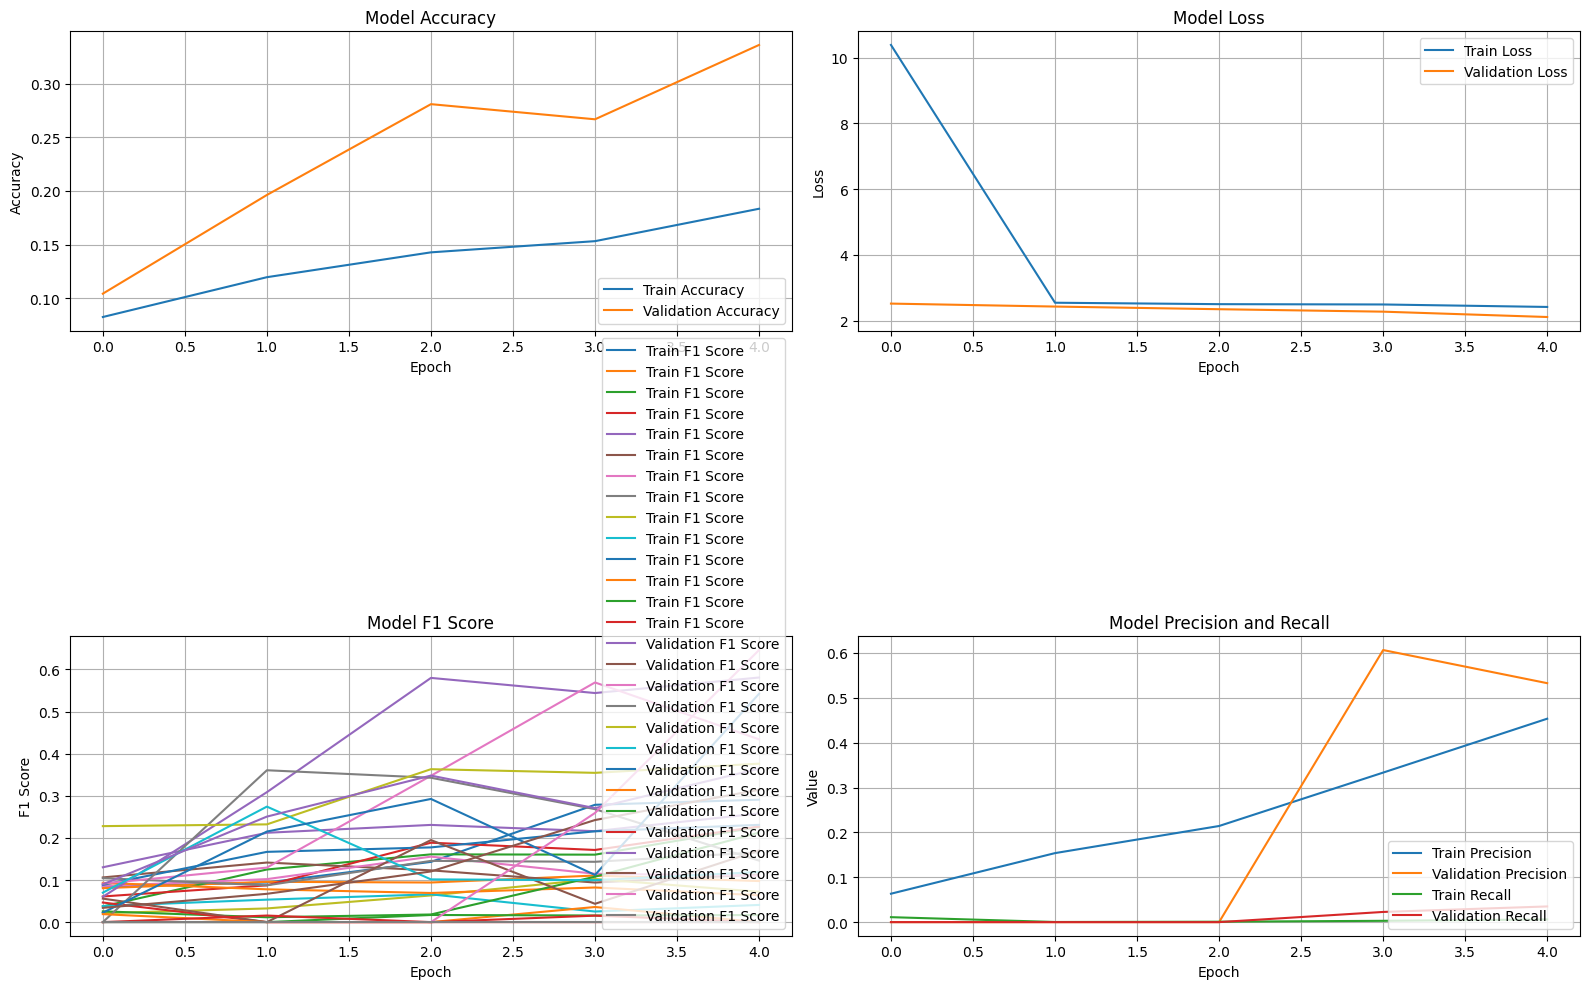

CPU times: total: 1h 12min 13s
Wall time: 8min 38s


In [144]:
%%time
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

# Define the Stratified Shuffle Split object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]
    
    history = cnn.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=5,
                      batch_size=512)

    display_metrics(history)


Current Model Overview:

Data Augmentation Layers: I integrated random rotations, translations, zooms, and horizontal flips directly into the network. These augmentations simulate various orientations and appearances of playing cards, helping the model generalize better.

Convolutional Layers: The model consists of two convolutional blocks. The first block has 32 filters and the second has 64 filters, both using a kernel size of 3x3 with 'same' padding to maintain the image dimensions. Each convolutional layer is followed by a ReLU activation function.

Pooling and Dropout: After the second convolutional block, there's a max pooling layer that reduces the spatial dimensions, which helps lower the number of parameters and computational load. To reduce overfitting, I included dropout layers after pooling and before the final classification layer.

Flattening and Dense Layers: I flatten the output from the convolutional layers into a 1D vector, which then passes through dense layers. The final dense layer, with softmax activation, outputs the probabilities across 53 classes (52 cards plus one potential class for the background or none).

Metrics and Compilation: The model uses the RMSprop optimizer and tracks metrics such as accuracy, precision, recall, and F1-score.

Performance Analysis

Initially, the model's performance was quite poor, with very low accuracy and F1-scores, indicating a struggle in effectively learning and differentiating the highly similar playing cards. To further enhance the model's performance, I plan to integrate batch normalization. This technique can accelerate training, improve model stability, and often leads to quicker convergence by normalizing the input layer and adjusting and scaling activations.

In [146]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, RandomRotation, RandomTranslation, RandomZoom, RandomFlip
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall

# Constants
img_wh = 224
NUM_CLASSES = 14

# Create the Sequential model as cnn2
cnn2 = Sequential()

# Start with an explicit Input layer
cnn2.add(Input(shape=(img_wh, img_wh, 3)))

# Data augmentation layers
cnn2.add(RandomRotation(factor=0.1))
cnn2.add(RandomTranslation(height_factor=0.1, width_factor=0.1))
cnn2.add(RandomZoom(height_factor=0.2))
cnn2.add(RandomFlip("horizontal"))

# First Convolutional Block
cnn2.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
cnn2.add(BatchNormalization())
cnn2.add(Activation('relu'))

# Increasing the number of filters in the subsequent layers
cnn2.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
cnn2.add(BatchNormalization())
cnn2.add(Activation('relu'))

# Adding additional convolutional layers
cnn2.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
cnn2.add(BatchNormalization())
cnn2.add(Activation('relu'))

# cnn2.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
# cnn2.add(BatchNormalization())
# cnn2.add(Activation('relu'))

# Pooling and Dropout
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.25))

# Using Global Average Pooling instead of Flatten
cnn2.add(GlobalAveragePooling2D())

# Dense Layers
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dropout(0.5))
cnn2.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
cnn2.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy','precision', 'recall', F1Score()]
)

# Display model summary
cnn2.summary()


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_48              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_40           │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_23 (RandomZoom)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_48 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_160 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_161 (Conv2D)             │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_63 (Activation)      │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_162 (Conv2D)             │ (None, 224, 224, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_64 (Activation)      │ (None, 224, 224, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,462 (439.30 KB)

 Trainable params: 112,014 (437.55 KB)

 Non-trainable params: 448 (1.75 KB)

: 

In [145]:
%%time
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

# Define the Stratified Shuffle Split object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]
    
    # Training the model
    history = cnn2.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=5,
                      batch_size=512)

    display_metrics(history)


Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node sequential_30_1/batch_normalization_39_1/moments/SquaredDifference defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\wnd\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\wnd\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 639, in run_forever

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1985, in _run_once

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\wnd\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\wnd\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\wnd\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\wnd\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\wnd\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\wnd\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\wnd\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\wnd\AppData\Local\Temp\ipykernel_334024\1680605174.py", line 1, in <module>

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 2478, in run_cell_magic

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\execution.py", line 1325, in time

  File "<timed exec>", line 13, in <module>

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 329, in fit

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 122, in one_step_on_iterator

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 110, in one_step_on_data

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 57, in train_step

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 826, in __call__

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\sequential.py", line 206, in call

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 199, in call

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\function.py", line 151, in _run_through_graph

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 583, in call

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 826, in __call__

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py", line 224, in call

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py", line 289, in _moments

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1726, in moments

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 724, in moments

  File "c:\Users\wnd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 767, in _compute_moments

OOM when allocating tensor with shape[512,224,224,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node sequential_30_1/batch_normalization_39_1/moments/SquaredDifference}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_532346]

My CNN initially showed some improvement, but adding complexity with batch normalization and extra layers didn't pan out as hoped. Despite batch normalization's promise for stable and efficient training, the model didn't perform well. Accuracy saw minor gains but overall stayed low, precision ticked up slightly suggesting some correct positive predictions, yet recall hovered near zero, indicating a broad failure to identify correct classes. The slight uptick in the F1 score wasn't nearly enough for a pat on the back. It seems the model may be overfitting, struggling with the nuances of the data, or just not cut out for this task with its current setup. It is time to test a different architecture. :)

#### Next Model Architecture - ResNet

In [127]:
from tensorflow.keras.layers import Add, Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomBrightness, RandomContrast

# Constants
img_wh = 224
NUM_CLASSES = 14 
l2_lambda = 0.000001

# Input layer
input_holder = Input(shape=(img_wh, img_wh, 3))

# Data augmentation layers
x = RandomFlip("horizontal")(input_holder)  # flip horizontally
x = RandomRotation(0.05)(x)  # rotate by 5%
x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x)  # move by 10%

# Residual Block 1
x = Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x_split = x

# Convolutional Layers
x = Conv2D(filters=16, kernel_size=(1, 1), kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), padding='same', activation='relu')(x_split)
x = Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), padding='same', activation='relu')(x)
x = Conv2D(filters=32, kernel_size=(1, 1), kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), padding='same', activation='relu')(x)

# Add the residual (shortcut connection)
x = Add()([x, x_split])
x = Activation('relu')(x)

# Pooling, Flatten, and Dense Layers
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

# Create and compile the model
resnet_model = Model(inputs=input_holder, outputs=x)
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','precision', Recall(name='recall'), F1Score()])

# Display the model summary and plot the model architecture
print(resnet_model.summary())
plot_model(resnet_model, to_file='resnet_model.png', show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96)


Model: "functional_325"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_41      │ (None, 224, 224,  │          0 │ input_layer_36[0… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_41  │ (None, 224, 224,  │          0 │ random_flip_41[0… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 224, 224,  │          0 │ random_rotation_… │
│ (RandomTranslation) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_131 (Conv2D) │ (None, 224, 224,  │        896 │ random_translati… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_66    │ (None, 112, 112,  │          0 │ conv2d_131[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_132 (Conv2D) │ (None, 112, 112,  │        528 │ max_pooling2d_66… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 112, 112,  │      9,280 │ conv2d_132[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_134 (Conv2D) │ (None, 112, 112,  │      2,080 │ conv2d_133[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 112, 112,  │          0 │ conv2d_134[0][0], │
│                     │ 32)               │            │ max_pooling2d_66… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (None, 112, 112,  │          0 │ add_5[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_67    │ (None, 56, 56,    │          0 │ activation_50[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_45          │ (None, 100352)    │          0 │ max_pooling2d_67… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 100352)    │          0 │ flatten_45[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_111 (Dense)   │ (None, 256)       │ 25,690,368 │ dropout_83[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, 256)       │          0 │ dense_111[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_112 (Dense)   │ (None, 14)        │      3,598 │ dropout_84[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 25,706,750 (98.06 MB)

 Trainable params: 25,706,750 (98.06 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


(6523, 224, 224, 3)
(6523, 14)
Epoch 1/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 303ms/step - accuracy: 0.0781 - f1_score: 0.0234 - loss: 515.7265 - precision: 0.0690 - recall: 0.0151 - val_accuracy: 0.0914 - val_f1_score: 0.0000e+00 - val_loss: 2.6311 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 303ms/step - accuracy: 0.0817 - f1_score: 0.0000e+00 - loss: 2.6290 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0871 - val_f1_score: 0.0000e+00 - val_loss: 2.6284 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 305ms/step - accuracy: 0.0896 - f1_score: 0.0000e+00 - loss: 2.6248 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0871 - val_f1_score: 0.0000e+00 - val_loss: 2.6215 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 299ms/step - accuracy: 0.0827 - f1_score: 0.0000e+00 - loss: 2.6195 - precision: 0.0000e+00 - recall: 

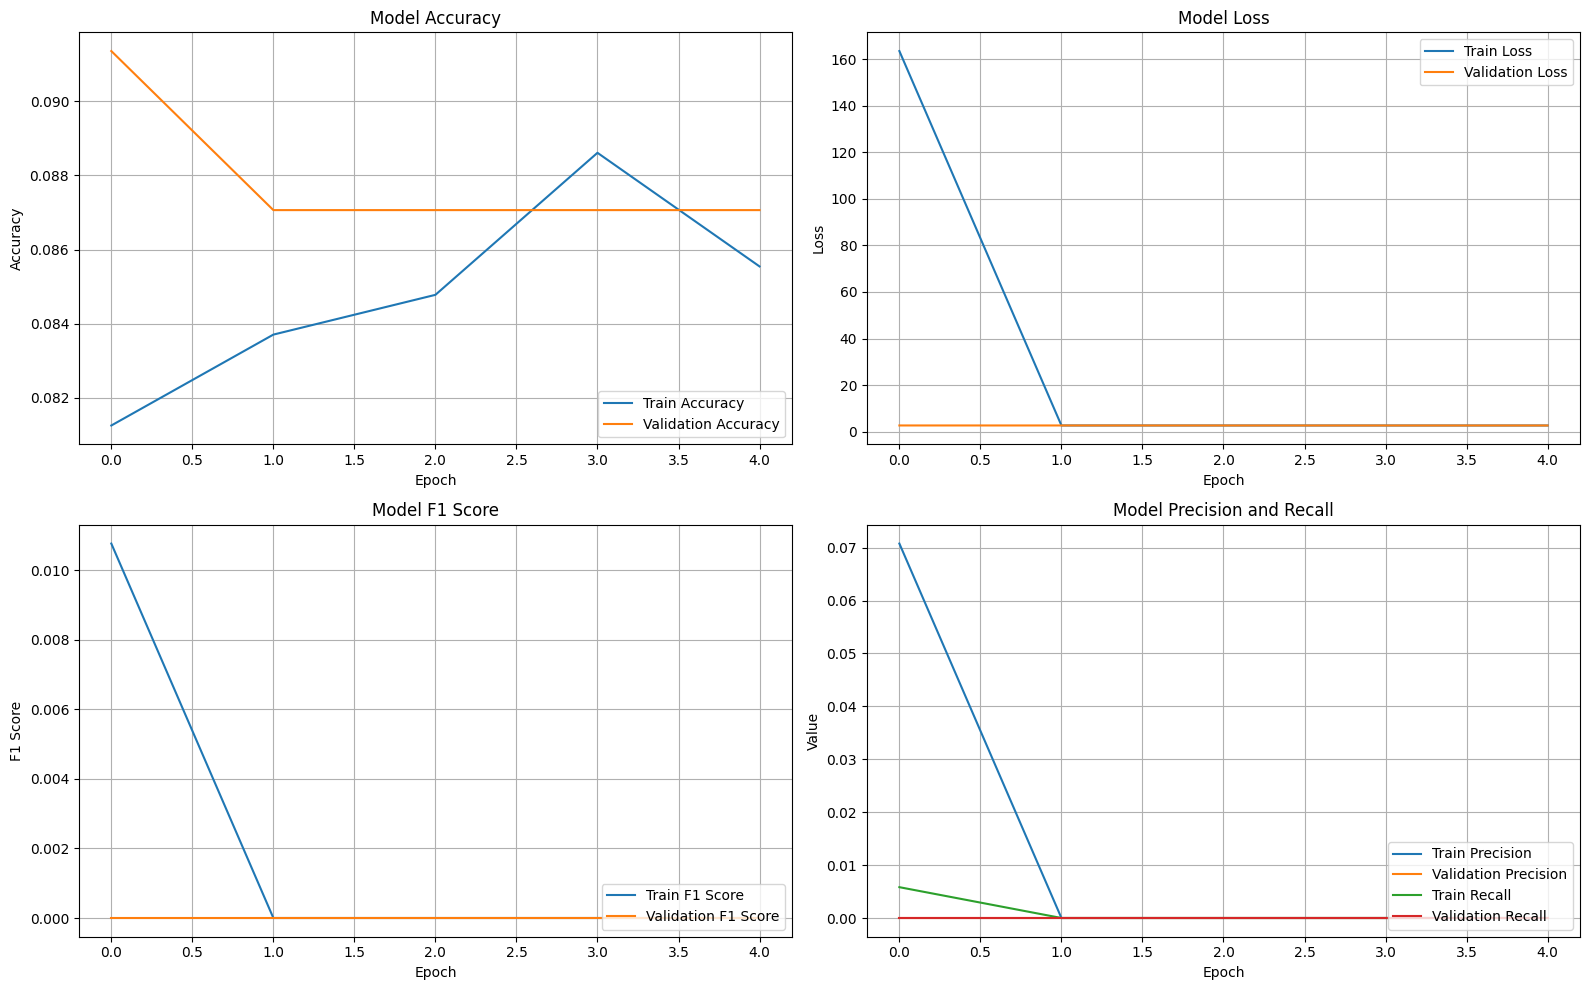

CPU times: total: 8min 32s
Wall time: 3min 30s


In [121]:
%%time
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

# Define the Stratified Shuffle Split object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]

    print(X_train.shape)
    print(y_train.shape)
    
    # Training the model
    history = resnet_model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=5,
                      batch_size=48)

    display_metrics(history)


The ResNet model's training outcomes are concerning, with accuracy stagnating around 8% and precision, recall, and F1 score effectively at zero after initial epochs. This pattern suggests the model is not learning meaningful patterns from the data. A loss spike in the first epoch and no improvements in key metrics hint at potential issues with either the model's architecture, the learning rate, or the data's representation.

In [133]:
from tensorflow.keras.layers import Add, Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomBrightness, RandomContrast
import tensorflow as tf

# Constants
img_wh = 224
NUM_CLASSES = 14
l2_lambda = 0.00001

# Input layer
input_holder = Input(shape=(img_wh, img_wh, 3))

# Data augmentation layers
x = RandomFlip("horizontal")(input_holder)
x = RandomRotation(0.05)(x)
x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x)
x = RandomBrightness(factor=0.1)(x)
x = RandomContrast(0.1)(x)

# Initial Convolutional Block
x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda))(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

# Residual Blocks
for _ in range(3):
    identity = x
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda))(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='linear', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda))(x)
    x = Add()([x, identity])
    x = Activation('relu')(x)

# Transition Layer
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Fully Connected Layers
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda))(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
resnet_model_2 = Model(inputs=input_holder, outputs=x)
resnet_model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','precision', Recall(name='recall')])

# Model summary
print(resnet_model_2.summary())


Model: "functional_333"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_45      │ (None, 224, 224,  │          0 │ input_layer_40[0… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_45  │ (None, 224, 224,  │          0 │ random_flip_45[0… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 224, 224,  │          0 │ random_rotation_… │
│ (RandomTranslation) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_brightness_… │ (None, 224, 224,  │          0 │ random_translati… │
│ (RandomBrightness)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_11  │ (None, 224, 224,  │          0 │ random_brightnes… │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_147 (Conv2D) │ (None, 112, 112,  │      9,472 │ random_contrast_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_74    │ (None, 56, 56,    │          0 │ conv2d_147[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_148 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_74… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_149 (Conv2D) │ (None, 56, 56,    │     36,928 │ conv2d_148[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 56, 56,    │          0 │ conv2d_149[0][0], │
│                     │ 64)               │            │ max_pooling2d_74… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 56, 56,    │          0 │ add_9[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_150 (Conv2D) │ (None, 56, 56,    │     36,928 │ activation_54[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 56, 56,    │     36,928 │ conv2d_150[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 56, 56,    │          0 │ conv2d_151[0][0], │
│                     │ 64)               │            │ activation_54[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 56, 56,    │          0 │ add_10[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 56, 56,    │     36,928 │ activation_55[0]

 Total params: 51,692,814 (197.19 MB)

 Trainable params: 51,692,814 (197.19 MB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.0765 - loss: 2.6519 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0981 - val_loss: 2.5698 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.0760 - loss: 2.6609 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0938 - val_loss: 2.6123 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.0744 - loss: 2.6488 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1245 - val_loss: 2.5894 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.0781 - loss: 2.6484 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1226 - val_loss: 2.5634 - val_precision: 0.3478 - val_recall: 0.0049
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.0857 - loss: 2.6480 - precision: 0.0000e+00 - re

KeyError: 'f1_score'

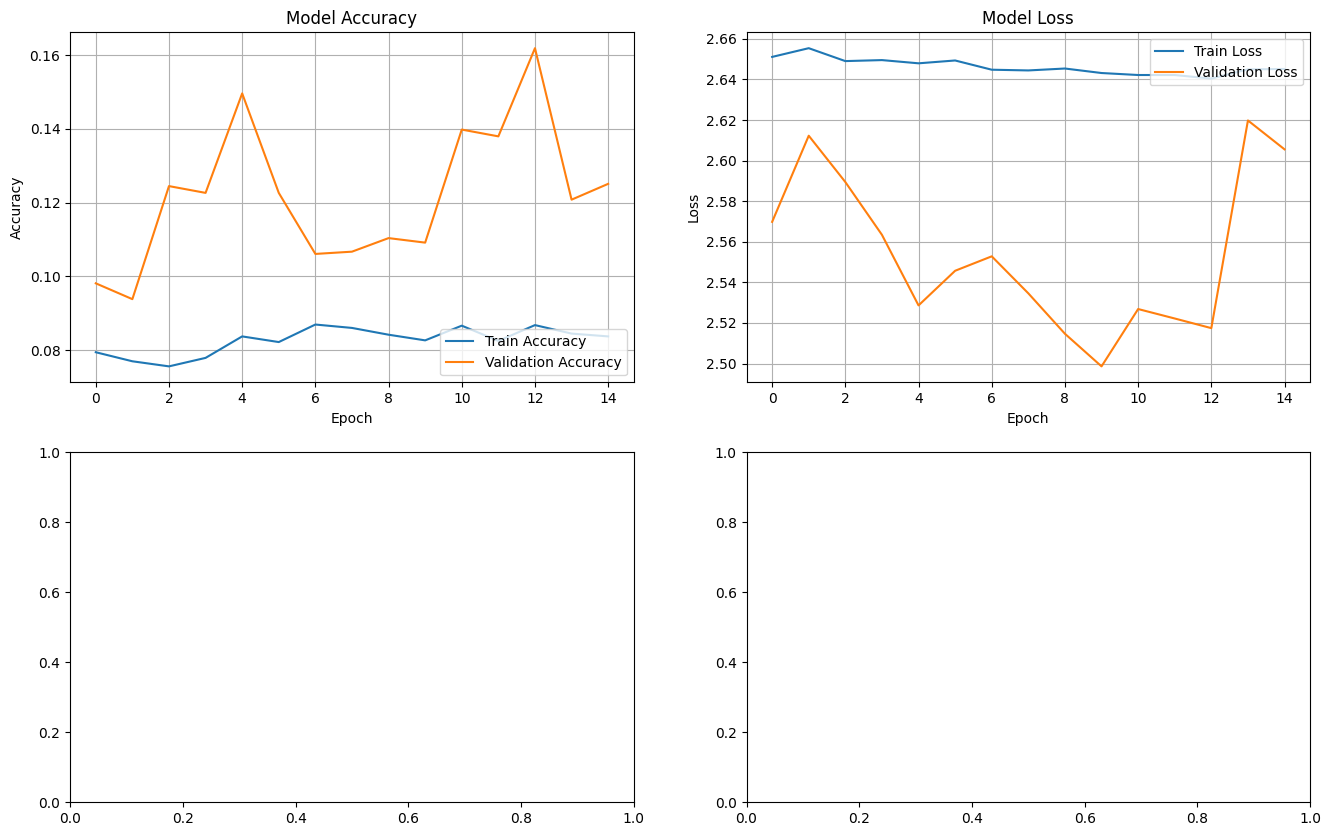

In [135]:
%%time
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

# Define the Stratified Shuffle Split object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]
    
    # Training the model
    history = resnet_model_2.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=15,  # Number of epochs
                      batch_size=512)  # Batch size

    display_metrics(history)


#### CNN Performance Comparison (1.5 points)
Visualize the final results of all the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

In [140]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the models on the test set as before and store the scores
scores_cnn = cnn.evaluate(X_test, y_test, verbose=0)
scores_cnn2 = cnn2.evaluate(X_test, y_test, verbose=0)
scores_resnet_model = resnet_model.evaluate(X_test, y_test, verbose=0)
scores_resnet_model_2 = resnet_model_2.evaluate(X_test, y_test, verbose=0)

# Extract the accuracy and precision for each model
accuracies = [scores_cnn[cnn.metrics_names.index('accuracy')],
              scores_cnn2[cnn2.metrics_names.index('accuracy')],
              scores_resnet_model[resnet_model.metrics_names.index('accuracy')],
              scores_resnet_model_2[resnet_model_2.metrics_names.index('accuracy')]]

precisions = [scores_cnn[cnn.metrics_names.index('precision')],
              scores_cnn2[cnn2.metrics_names.index('precision')],
              scores_resnet_model[resnet_model.metrics_names.index('precision')],
              scores_resnet_model_2[resnet_model_2.metrics_names.index('precision')]]

# Define labels, positions, and bar width
labels = ['cnn', 'cnn2', 'resnet_model', 'resnet_model_2']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Plot accuracy
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')

# Plot precision
rects2 = ax.bar(x + width/2, precisions, width, label='Precision')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Accuracy and Precision of Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to attach a text label above each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function for each set of bars
autolabel(rects1)
autolabel(rects2)

# Show the plot
plt.show()


ValueError: 'accuracy' is not in list

#### Comparison with MLP (1 point)
Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

### Exceptional Work (1 point total)
- **Additional Analysis:** [Describe any additional analyses performed, such as using transfer learning with pre-trained weights and comparing its performance to your other models.]



## Conclusion
[Summarize the findings, challenges faced, and any insights gained from the lab exercise.]